In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.othermod.betareg import BetaModel

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_pred = os.path.join(pth_data, 'modeling', 'predict')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling', 'regression')
pth_reg = os.path.join('..', 'regression')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_pred, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = src,
                          random_state = 1234)
        adata.obs.loc[msk, src] = adata_group.obs[src]

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# training split
grp_train = (adata[adata.obs.training == 'True'].obs
             .groupby('celltype', observed = True)
             .filter(lambda g: len(g) > 160)
             .groupby('celltype', observed = True))
src_reg = list(feat_dict.keys())
X_train = grp_train[src_reg].mean()
mu = X_train.mean().rename('mu')
sigma = X_train.std().rename('sigma')
X_train = sm.add_constant(X_train
                          .sub(mu, axis = 1)
                          .div(sigma, axis = 1))
z_train = grp_train.latent_z.mean()

# validation split
grp_val = (adata[adata.obs.validation == 'True'].obs
           .groupby('celltype', observed = True)
           .filter(lambda g: g.name in X_train.index)
           .groupby('celltype', observed = True))
X_val = grp_val[src_reg].mean()
X_val = sm.add_constant(X_val
                        .sub(mu, axis = 1)
                        .div(sigma, axis = 1))
z_val = grp_val.latent_z.mean()

# beta regression
reg = BetaModel(z_train, X_train).fit()
beta = reg.params.drop('precision').rename('beta')
reg_out = pd.concat((beta, mu, sigma), axis = 1)
reg_out.to_csv(os.path.join(pth_reg, 'betareg.csv'))
z_pred = reg.predict(X_val)

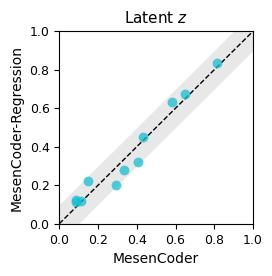

In [6]:
# plot fit (validation)
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
ax.scatter(z_val, z_pred,
           color = 'tab:cyan',
           s = 50, alpha = .75,
           linewidth = 0,
           zorder = 100)
lim = np.asarray((0, 1))
ax.plot(lim, lim,
        c = 'k',
        ls = '--',
        linewidth = 1,
        zorder = 10)
ax.fill_between(lim,
                lim - .1, lim + .1,
                color = 'lightgray',
                alpha = .5,
                linewidth = 0,
                zorder = 0)

ax.set_xlim(lim); ax.set_ylim(lim)
ticks = np.arange(lim[0], lim[1] + .1, .2).round(1)
ax.set_xticks(ticks, ticks, size = 9)
ax.set_yticks(ticks, ticks, size = 9)
ax.set_title(r'Latent $z$', size = 11)
ax.set_xlabel('MesenCoder', size = 10)
ax.set_ylabel('MesenCoder-Regression', size = 10)
fn = os.path.join(pth_out, 'betareg.pdf')
plt.savefig(fn, bbox_inches = 'tight')

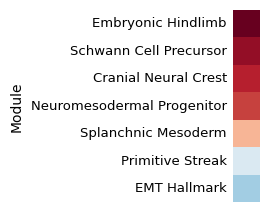

In [7]:
# plot coefficients
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
beta_plt = pd.DataFrame(beta.drop('const')
                        .sort_values(ascending = False))
beta_plt.index = df.loc[beta_plt.index].Name.values
sns.heatmap(beta_plt,
            cmap = 'RdBu_r',
            center = 0,
            square = True,
            cbar = False,
            ax = ax)
ax.set_xticks([])
ax.tick_params('y', size = 0, pad = 4, labelsize = 9.5)
ax.set_ylabel('Module', size = 10, labelpad = 5)
fn = os.path.join(pth_out, 'coefficients.pdf')
plt.savefig(fn, bbox_inches = 'tight')